In [1]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as pdr
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.varmax import VARMAX
import math

In [2]:
yf.pdr_override()
y_symbols = ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'MSFT']

In [3]:
startdate = dt.datetime(2015,1,1)
enddate = dt.datetime(2021,1, 1)

In [4]:
data = pdr.get_data_yahoo(y_symbols, start=startdate, end=enddate)

[*********************100%%**********************]  5 of 5 completed


In [5]:
data.head()

Adj Close                                                Close   
                 AAPL     AMZN       GOOG       MSFT       TSLA       AAPL   
Date                                                                         
2015-01-02  24.498686  15.4260  26.168653  40.534851  14.620667  27.332500  \
2015-01-05  23.808519  15.1095  25.623152  40.162102  14.006000  26.562500   
2015-01-06  23.810759  14.7645  25.029282  39.572613  14.085333  26.565001   
2015-01-07  24.144638  14.9210  24.986401  40.075401  14.063333  26.937500   
2015-01-08  25.072329  15.0230  25.065184  41.254341  14.041333  27.972500   

                                                      ...       Open            
               AMZN       GOOG       MSFT       TSLA  ...       AAPL     AMZN   
Date                                                  ...                       
2015-01-02  15.4260  26.168653  46.759998  14.620667  ...  27.847500  15.6290  \
2015-01-05  15.1095  25.623152  46.330002  14.006000  ...  27.072500  15.3505   
2015-01-06  14.7645  25.029282  45.650002  14.085333  ...  26.635000  15.1120   
2015-01-07  14.9210  24.986401  46.230000  14.063333  ...  26.799999  14.8750   
2015-01-08  15.0230  25.065184  47.590000  14.041333  ...  27.307501  15.0160   

                                                Volume                       
                 GOOG       MSFT       TSLA       AAPL      AMZN      GOOG   
Date                                                                         
2015-01-02  26.378078  46.660000  14.858000  212818400  55664000  28951268  \
2015-01-05  26.091366  46.369999  14.303333  257142000  55484000  41196796   
2015-01-06  25.679497  46.380001  14.004000  263188400  70380000  57998800   
2015-01-07  25.280592  45.980000  14.223333  160423600  52806000  41301082   
2015-01-08  24.831326  46.750000  14.187333  237458000  61768000  67071641   

                                
                MSFT      TSLA  
Date                            
2015-01-02  27913900  71466000  
2015-01-05  39673900  80527500  
2015-01-06  36447900  93928500  
2015-01-07  29114100  44526000  
2015-01-08  29645200  51637500  

[5 rows x 30 columns]

Text(0.5, 1.0, 'Stock prices')

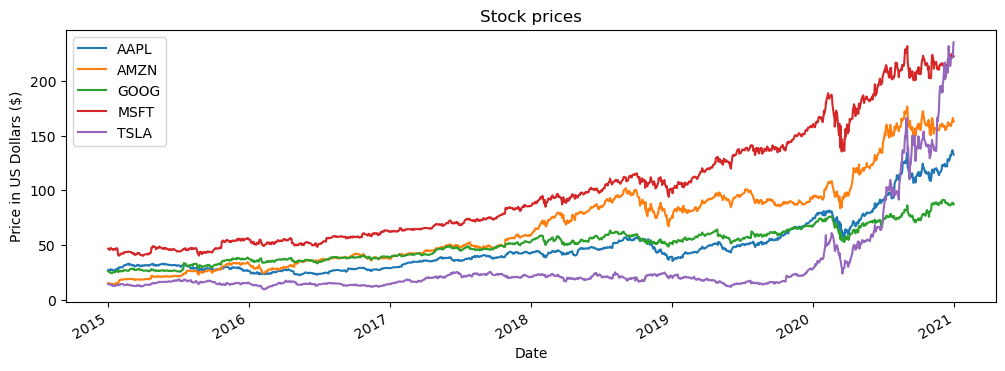

In [6]:
data.Close.plot(figsize = (12, 4))
plt.xlabel('Date')
plt.ylabel('Price in US Dollars ($)')
plt.title('Stock prices')

Most of the variation seems to happen between 2020 and 2021. Lets take a closer look

<Axes: xlabel='Date'>

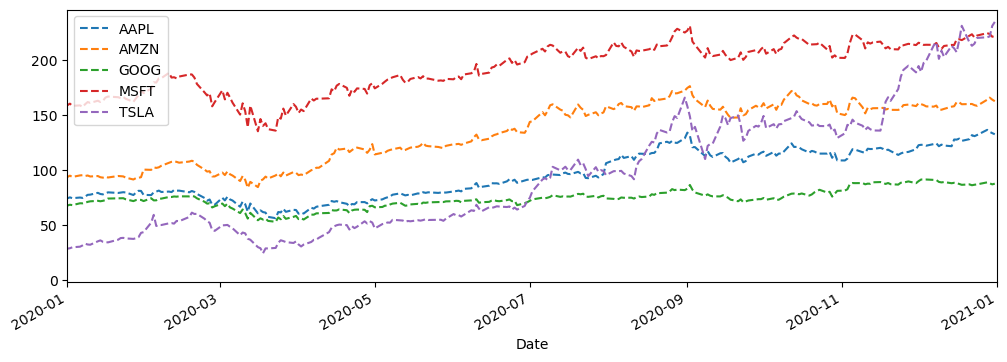

In [7]:
data.Close.plot(xlim = ['2020-01-01', '2021-01-01'], ls = '--', figsize = (12, 4))

[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Prices')

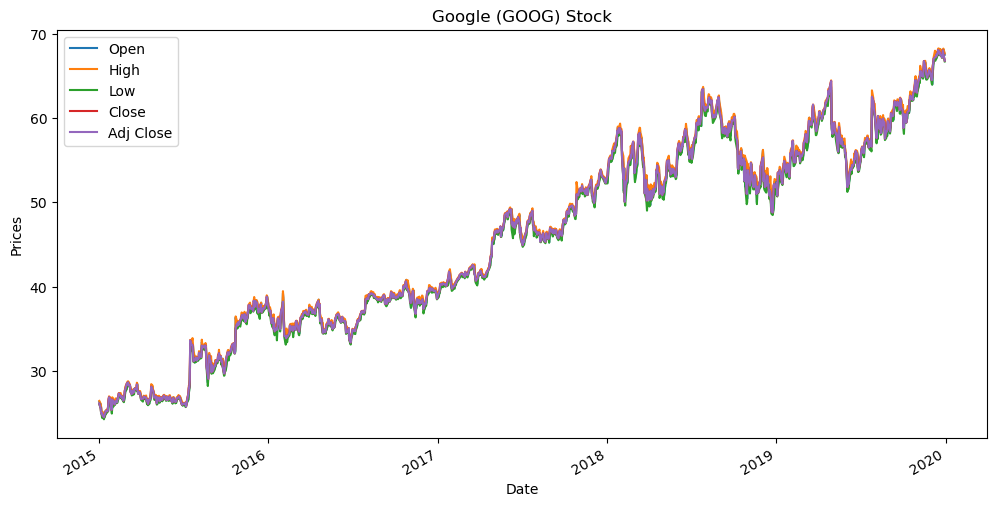

In [9]:
data = pdr.get_data_yahoo(['GOOG'], start='2015-01-01', end='2019-12-31')
data.iloc[:, :-1].plot(figsize = (12, 6))
plt.title('Google (GOOG) Stock')
plt.ylabel('Prices')

### ANALYZE GOOGLE STOCK

In [9]:
data = pdr.get_data_yahoo(['GOOG'], start='2015-01-01', end='2019-12-31')
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


In [10]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1257.000000,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03
mean,45.649916,46.038350,45.260461,45.663827,45.663827,3.415121e+07
std,11.523511,11.629350,11.441770,11.539933,11.539933,1.697418e+07
min,24.664783,24.730902,24.311253,24.560070,24.560070,6.950000e+06
25%,36.463501,36.737000,36.116798,36.448002,36.448002,2.426200e+07
50%,46.477001,46.694000,46.172249,46.467999,46.467999,2.976400e+07
75%,55.632999,56.210999,55.183250,55.756500,55.756500,3.899600e+07
max,68.167503,68.250000,67.633499,68.058502,68.058502,2.232980e+08


<Axes: xlabel='Date'>

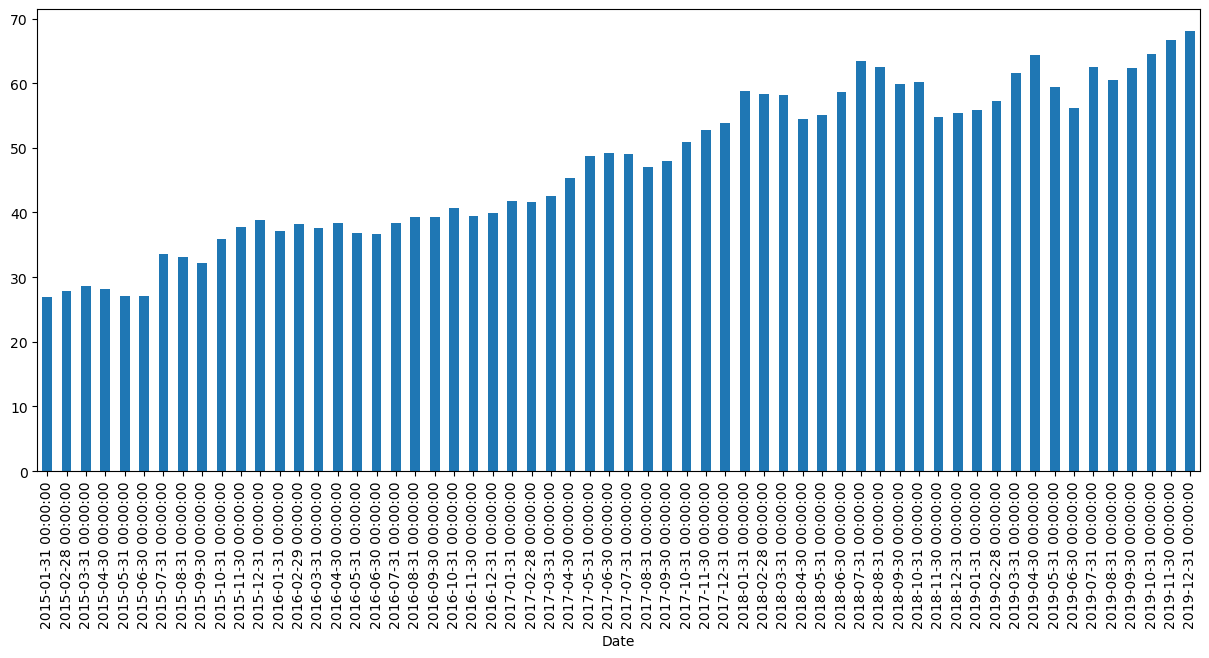

In [11]:
data.Close.resample(rule = 'M').max().plot(kind = 'bar', figsize = (15, 6))

Text(0, 0.5, 'Prices')

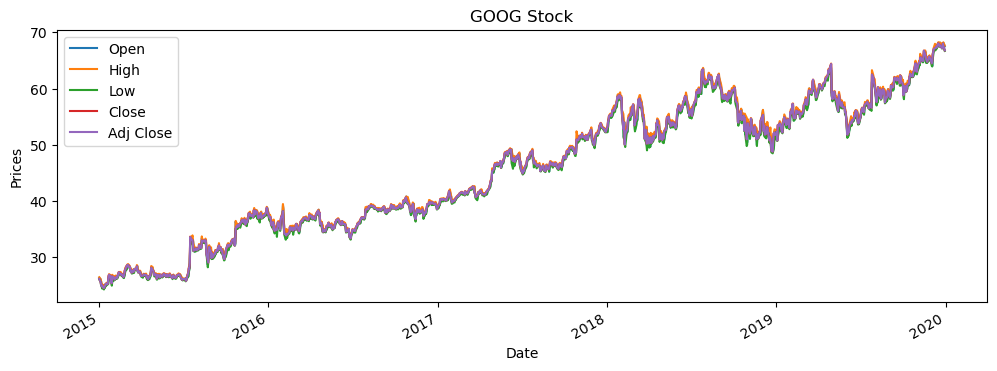

In [12]:
data.iloc[:, :-1].plot(figsize = (12, 4))
plt.title('GOOG Stock')
plt.ylabel('Prices')

<Axes: xlabel='Date'>

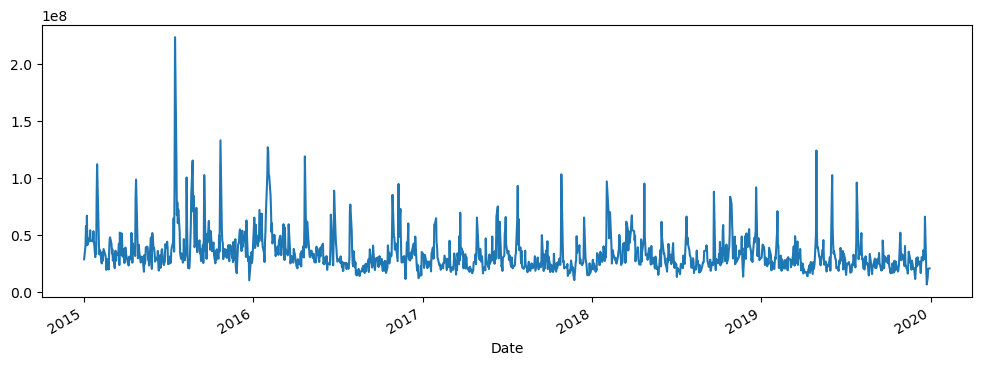

In [13]:
data.Volume.plot(figsize = (12, 4))

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

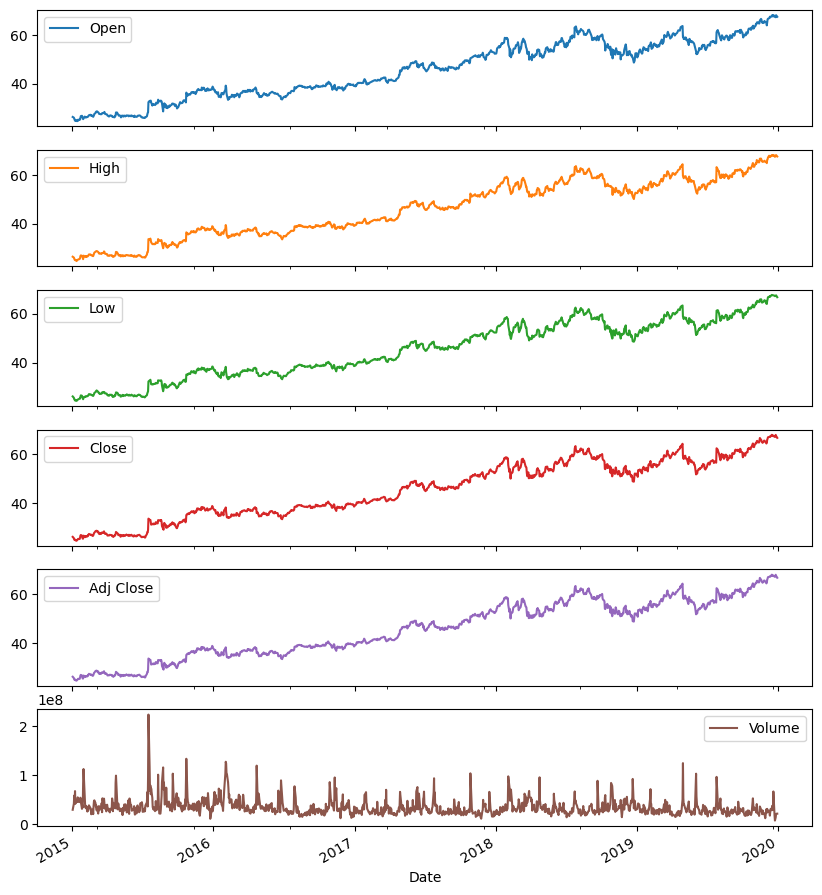

In [14]:
data.plot(subplots = True, figsize = (10, 12))

Lets look at the close value of the stock

<Axes: xlabel='Date'>

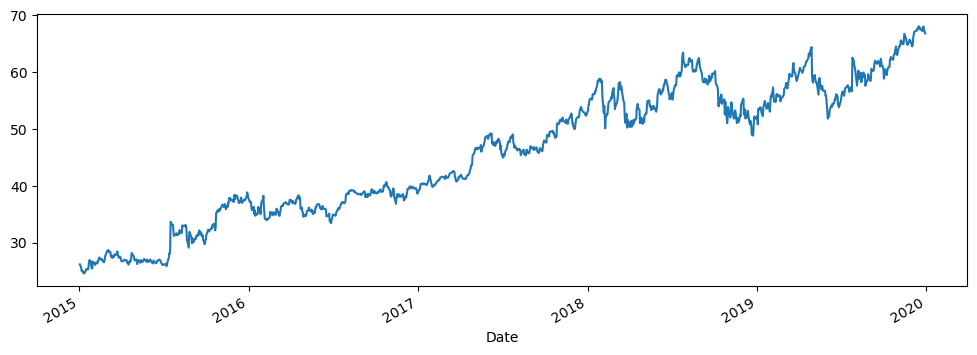

In [15]:
data.Close.plot(figsize = (12, 4))

Text(0.5, 1.0, 'Distribution of close prices over the days')

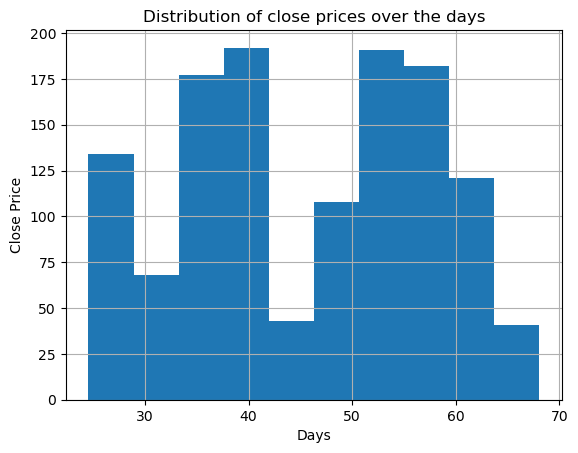

In [16]:
data.Close.hist()
plt.ylabel('Close Price')
plt.xlabel('Days')
plt.title('Distribution of close prices over the days')

In [17]:
data.Close.rolling(10).mean()

Date
2015-01-02          NaN
2015-01-05          NaN
2015-01-06          NaN
2015-01-07          NaN
2015-01-08          NaN
                ...    
2019-12-23    67.555800
2019-12-24    67.550300
2019-12-26    67.627200
2019-12-27    67.635300
2019-12-30    67.576849
Name: Close, Length: 1257, dtype: float64

### Simple Moving Average

Moving Average:
Average of the last n days

In [18]:
#Calculate moving average of first 50 days
ma20 = data.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50 = data.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100 = data.Close.rolling(100).mean()
#Calculate moving average of first 200 days
ma200 = data.Close.rolling(200).mean()

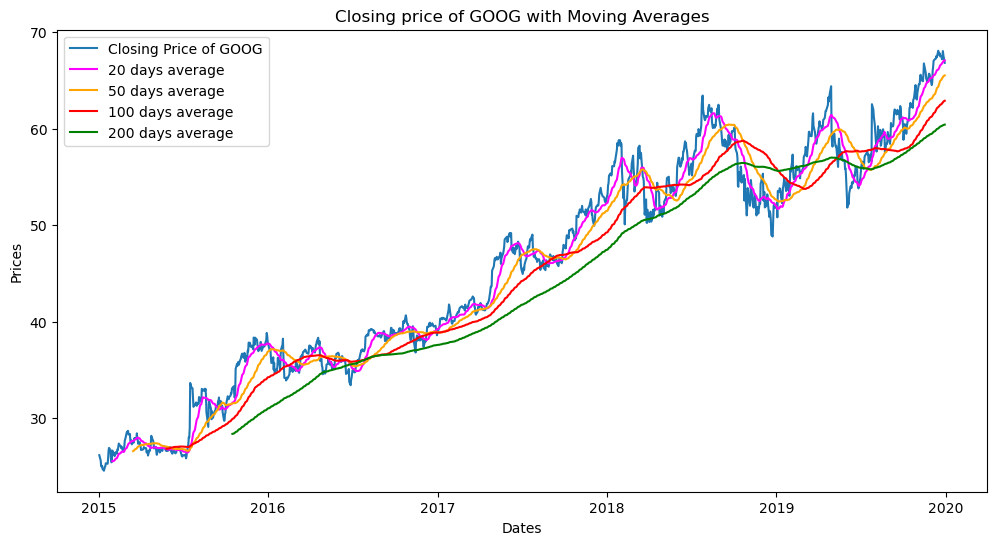

In [19]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(ma20, 'magenta', label = '20 days average')
plt.plot(ma50, 'orange', label = '50 days average')
plt.plot(ma100, 'r', label = '100 days average')
plt.plot(ma200, 'g', label = '200 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Moving Averages')
plt.legend()

For 2019

In [20]:
data_2019 = pdr.get_data_yahoo(['GOOG'], start='2019-01-01', end='2019-12-31')
data_2019.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000


In [21]:
#2019
#Calculate moving average of first 50 days
ma20_2019 = data_2019.Close.rolling(20).mean()
#Calculate moving average of first 50 days
ma50_2019 = data_2019.Close.rolling(50).mean()
#Calculate moving average of first 100 days
ma100_2019 = data_2019.Close.rolling(100).mean()

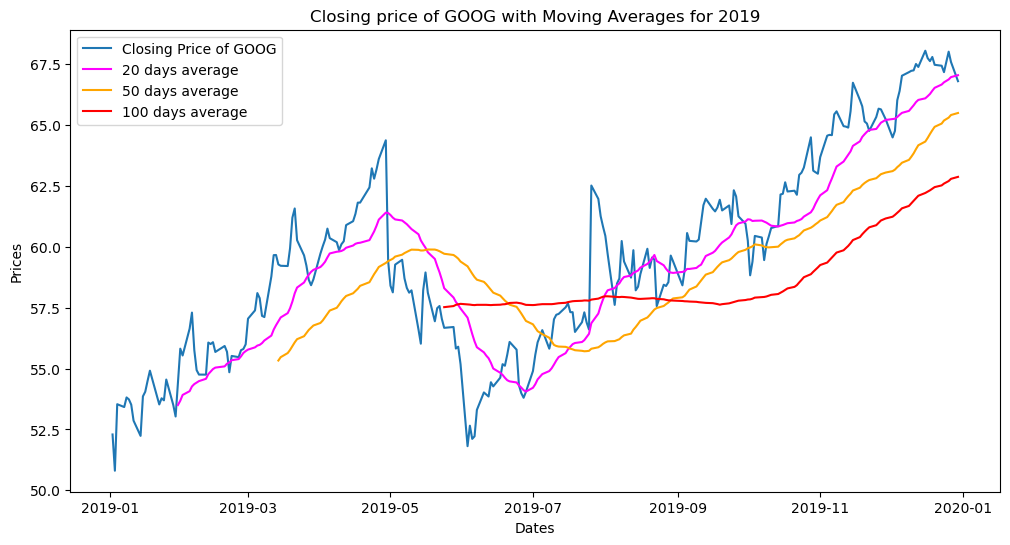

In [22]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(ma20_2019, 'magenta', label = '20 days average')
plt.plot(ma50_2019, 'orange', label = '50 days average')
plt.plot(ma100_2019, 'r', label = '100 days average')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Moving Averages for 2019')
plt.legend()

### Cumulative Moving Average

In [23]:
cma_aapl = data.Close.expanding().mean()

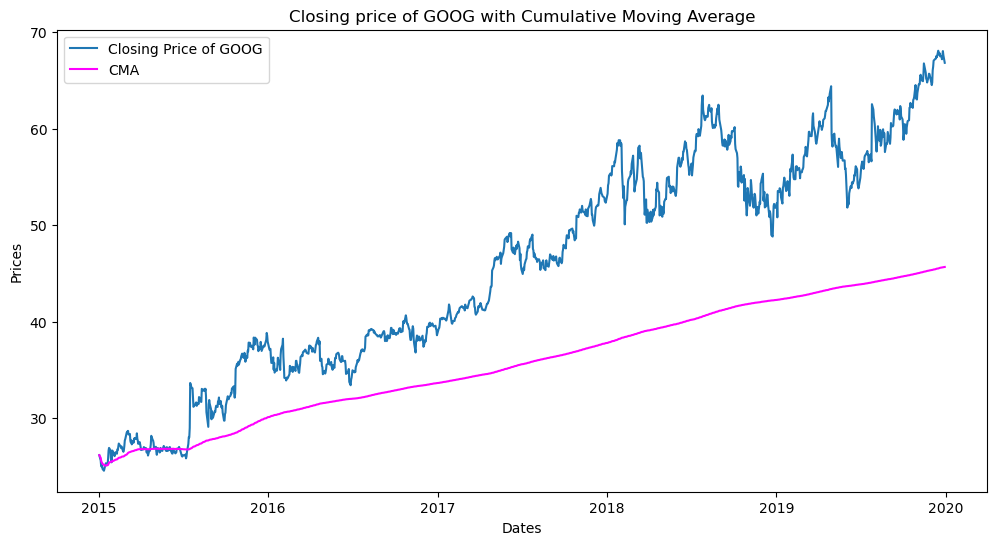

In [24]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(cma_aapl, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Cumulative Moving Average')
plt.legend()

In [25]:
#for 2019
cma_2019 = data_2019.Close.expanding().mean()

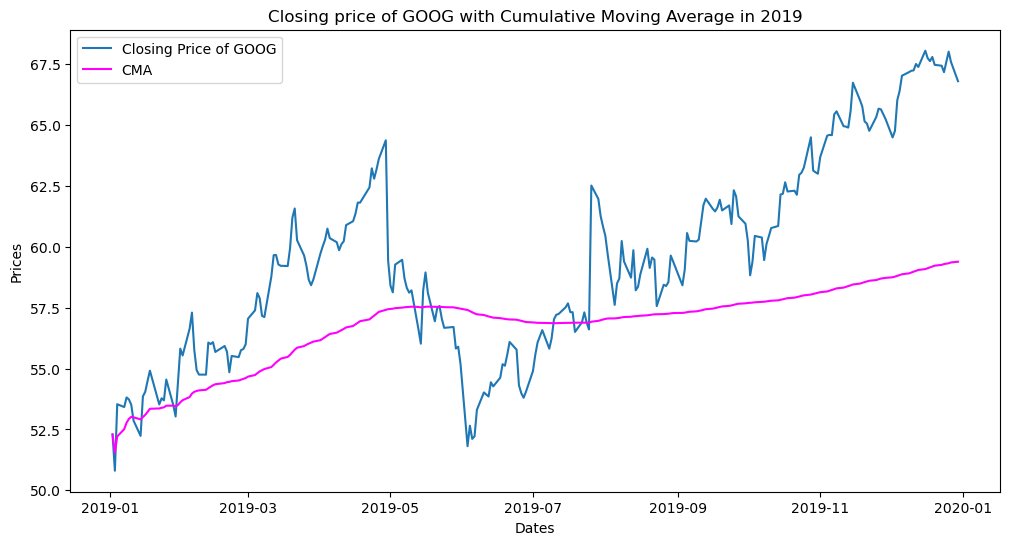

In [26]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(cma_2019, 'magenta', label = 'CMA')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Cumulative Moving Average in 2019')
plt.legend()

### Exponential Weighted Moving Average (EWMA)

$ewma(t) = a * x(t) + (1-a) * ewma(t-1)$

where, $a \implies$ weight factor that gives higher priority to the price at time $t$ compared to the price at $t-1$ (This is done to prevent lags)

In [27]:
ewma_0 = data.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1 = data.Close.ewm(alpha = 0.3, adjust = False).mean()

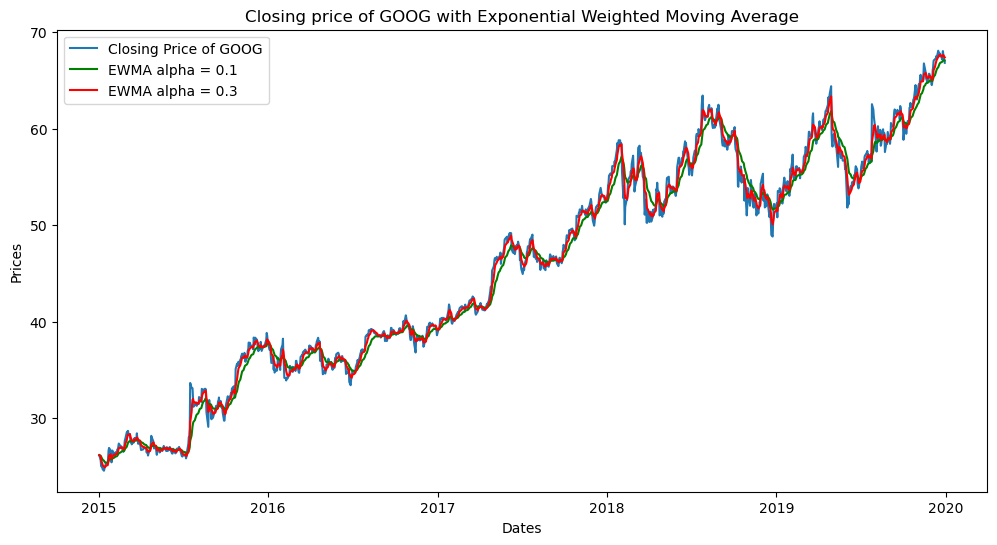

In [28]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close, label = 'Closing Price of GOOG')
plt.plot(ewma_0, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Exponential Weighted Moving Average')
plt.legend()

In [29]:
#for 2019
ewma_0_2019 = data_2019.Close.ewm(alpha = 0.1, adjust = False).mean()
ewma_1_2019 = data_2019.Close.ewm(alpha = 0.3, adjust = False).mean()

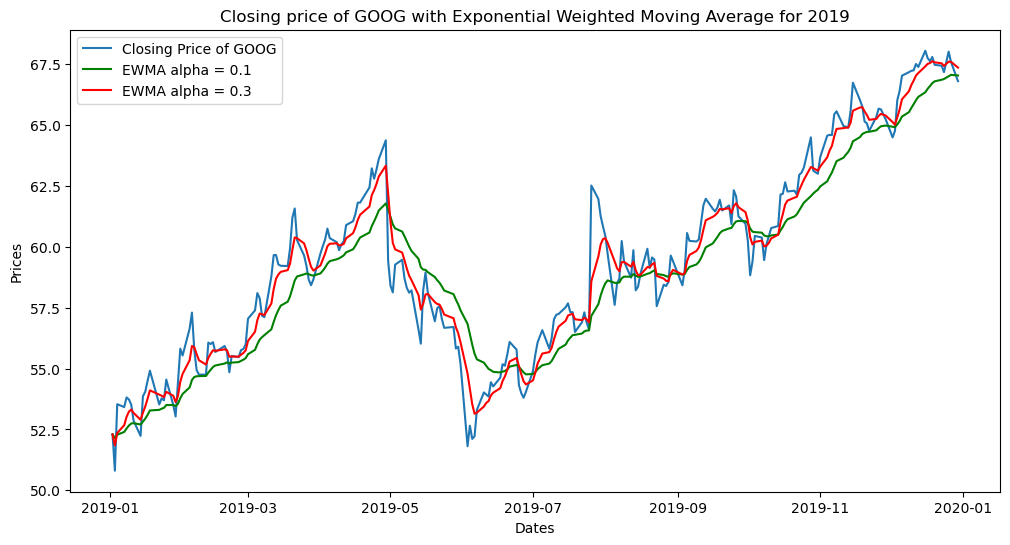

In [30]:
plt.figure(figsize = (12, 6))
plt.plot(data_2019.Close, label = 'Closing Price of GOOG')
plt.plot(ewma_0_2019, 'g', label = 'EWMA alpha = 0.1')
plt.plot(ewma_1_2019, 'r', label = 'EWMA alpha = 0.3')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Closing price of GOOG with Exponential Weighted Moving Average for 2019')
plt.legend()